In [3]:
!pip install PyDrive

from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks/GAN"

    100% |████████████████████████████████| 993kB 18.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
celeba	 dcgan-G	svhn		     wgp_dcgan-D  wgp_dcgan_samples
dcgan-D  dcgan_samples	Ver1_DCGAN_GP.ipynb  wgp_dcgan-G


In [4]:
!ls "/content"

drive  sample_data


#### Libraries

In [0]:
%matplotlib inline

from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


In [0]:
dataroot = "/content/drive/My Drive/Colab Notebooks/GAN/svhn/"

workers = 4

batch_size = 64

image_size = 32


nc = 3

nz = 100

#### SVHN dataloader

In [8]:
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import dataset
import torchvision.datasets as dset
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

datapath = '/content/drive/My Drive/Colab Notebooks/GAN/svhn'

image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5),
                         (.5, .5, .5))
])


def get_data_loader(dataset_location, batch_size):
    trainvalid = torchvision.datasets.SVHN(
        dataset_location, split='train',
        download=True,
        transform=image_transform
    )

    trainset_size = int(len(trainvalid) * 0.9)
    trainset, validset = dataset.random_split(
        trainvalid,
        [trainset_size, len(trainvalid) - trainset_size]
    )

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    validloader = torch.utils.data.DataLoader(
        validset,
        batch_size=batch_size,
    )

    testloader = torch.utils.data.DataLoader(
        torchvision.datasets.SVHN(
            dataset_location, split='test',
            download=True,
            transform=image_transform
        ),
        batch_size=batch_size,
    )

    return trainloader, validloader, testloader

trainloader, validloader, testloader = get_data_loader(datapath, batch_size)


device = torch.device("cpu")


Using downloaded and verified file: /content/drive/My Drive/Colab Notebooks/GAN/svhn/train_32x32.mat
Using downloaded and verified file: /content/drive/My Drive/Colab Notebooks/GAN/svhn/test_32x32.mat


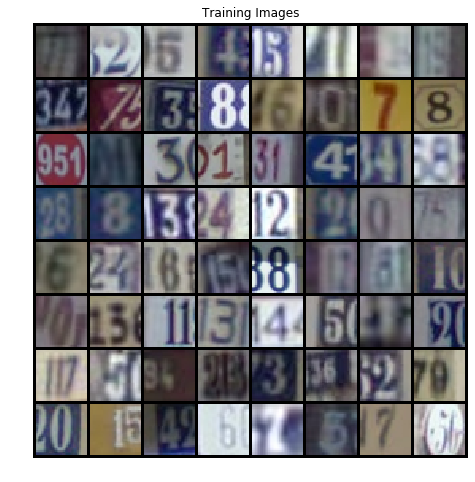

In [9]:
# Plot some training images
real_batch = next(iter(trainloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:batch_size], padding=2, normalize=True),(1,2,0)))

In [0]:
####### TODO -> replace with import 


class Generator(nn.Module):

    def __init__(self, f=32):
        super(Generator, self).__init__()

        # base depth nb of feature maps
        self.f = f

        def dc_block(in_size, out_size, k=4, s=2, p=1):
            return nn.Sequential(
                nn.ConvTranspose2d(in_size, out_size, k, s, p, bias=False),
                nn.BatchNorm2d(out_size),
                nn.ReLU(True))

        self.main = nn.Sequential(
            dc_block(100, self.f * 8, 2, 1, 0),
            dc_block(self.f * 8, self.f * 4),
            dc_block(self.f * 4, self.f * 2),
            dc_block(self.f * 2, self.f),
            nn.ConvTranspose2d(self.f, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )


    def forward(self, z):
        return self.main(z)

In [0]:
G_filename = '/content/drive/My Drive/Colab Notebooks/GAN/dcgan-G'

G = Generator()
G.load_state_dict(torch.load(G_filename, map_location='cpu'))
G.eval()

for p in G.parameters():
        p.requires_grad = False

# Nouvelle section

Random Seed:  93919


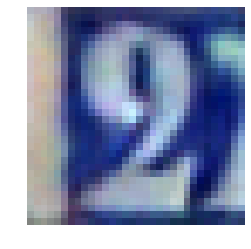

In [278]:
## show G(z)

#gpu manualSeed = 4591
manualSeed = 93919
#59 : 5945 43 : 87256 2: 95336 23:13360 18:16545
#manualSeed = random.randint(1, 100000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


z = torch.randn(1, nz, 1, 1)

def get_Gz(G,z,padding=2):
  images = G(z).detach().cpu()
  return np.transpose(vutils.make_grid(images, padding=padding, nrow=z.size()[0], normalize=True), (1,2,0))

plt.axis("off")
plt.imshow(get_Gz(G,z))

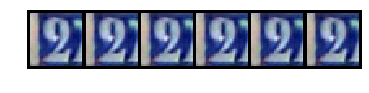

In [289]:
def perturbation(epsilon, i, z):
  ze = torch.zeros_like(z)
  ze[0][i][0][0] += epsilon
  
  return z + ze

def slide(epsilon, i, z, length=5):
  img_list = z
  for j in range(length+1):
    if j == 0:
        continue
    img_list = torch.cat((img_list, perturbation(j*epsilon, i, z)), 0)
  
  return img_list


for i in range(nz):
  slider = get_Gz(G,slide(0.1,i,z))
  #plt.title("dim : %d",i)
  plt.axis("off")
  plt.imshow(slider)
  #plt.close()

In [0]:
show 5 interesting 

idx = [i,i,i,i,i]

make grid 100 (5 x 10)
  for array 
    make gid of tuples (G(zi),G(zi+e))

In [0]:
enumerate of z_alpha

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [0]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(trainloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:batch_size], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [0]:
G_filename = '/content/drive/My Drive/Colab Notebooks/GAN/wgp_dcgan-G'

torch.load(netG.state_dict(), G_filename)

In [0]:
import os

def save_samples(dir):
    G =  Generator().to(device)
    G.load_state_dict(torch.load(G_filename))
    G.eval()
    
    for p in G.parameters():
        p.requires_grad = False

    for i in range(10):
        print(i)
        noise = torch.randn(100, nz, 1, 1, device=device)
        images = G(noise)
        os.makedirs(f"{img_dir}/img/", exist_ok=True)
        for j, image in enumerate(images):
            filename = f"{img_dir}/img/{i * 100 + j:03d}.png"
            torchvision.utils.save_image(image, filename, normalize=True)

In [0]:
wgp_dcgan_samples = '/content/drive/My Drive/Colab Notebooks/GAN/wgp_dcgan_samples'

save_samples(wgp_dcgan_samples)